## Figures

- Figure 6 D,E,G,J

## Required files

- `{model_dir}/deeplift/{task}/out/{imp_score}/modisco.h5`
- `{model_dir}/deeplift.imp_score.h5`
- `{model_dir}/deeplift/{tf}/out/{imp_score}/pattern_table.csv`

## Produced files

`fdir = f'{ddir}/figures/modisco/{exp}/periodicity/'`

- Figure 6D
  - `{fdir}/m0_p1.contrib.pdf`
  - `{fdir}/m0_p1.pfm.pdf`
- Figure 6E
  - `{fdir}/Nanog.p1.heatmap+avg.pdf`
- Figure 6G
  - `{fdir}/Nanog.p1.fft.pdf`
- Figure 6J
  - `{fdir}/10bp-periodicity.boxplot.pdf`
  - `{fdir}/10bp-periodicity.boxplot.labeled.pdf`  

In [5]:
from collections import OrderedDict
exp = 'nexus,peaks,OSNK,0,10,1,FALSE,same,0.5,64,25,0.004,9,FALSE,[1,50],TRUE'
imp_score = 'profile/wn'

In [6]:
from basepair.imports import *
from basepair.exp.paper.config import *
from basepair.modisco.periodicity import compute_power_spectrum, periodicity_10bp_frac, plot_power_spectrum

import matplotlib.ticker as ticker
from basepair.plot.profiles import extract_signal
from basepair.utils import pd_col_prepend
from basepair.modisco.table import ModiscoData

paper_config()

In [4]:
# figures dir
model_dir = models_dir / exp
fdir = Path(f'{ddir}/figures/modisco/{exp}/periodicity/')
fdir.mkdir(parents=True, exist_ok=True)

In [5]:
task = 'Nanog'
modisco_dir = model_dir / f'deeplift/{task}/out/{imp_score}/'

In [6]:
mr = ModiscoResult(modisco_dir / 'modisco.h5')

In [7]:
p = mr.get_pattern("metacluster_0/pattern_1")

In [8]:
w = get_figsize(.6, 1/12)[0]

In [9]:
w / 70

0.05871754285714286

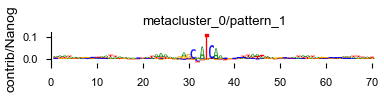

In [10]:
# fig = plt.figure(figsize=get_figsize(.6, 1/12))
p.plot("contrib", letter_width=0.06, height=0.4);
sns.despine(top=True, right=True, bottom=True)
plt.savefig(fdir / 'm0_p1.contrib.pdf')

TF-MoDISco is using the TensorFlow backend.


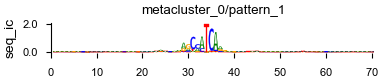

In [11]:
# fig = plt.figure(figsize=get_figsize(.6, 1/12))
p.plot("seq_ic", letter_width=0.06, height=0.4);
sns.despine(top=True, right=True, bottom=True)
plt.savefig(fdir / 'm0_p1.pfm.pdf')

In [12]:
md = ModiscoData.load(modisco_dir, None)

100%|██████████| 19/19 [1:04:30<00:00, 202.69s/it]


In [13]:
def plot_power_spectrum(pattern, task, data, figwidth=10):
    seqlets = data.seqlets_per_task[pattern]
    wide_seqlets = [s.resize(data.footprint_width)
                    for s in seqlets
                    if s.center() > data.footprint_width // 2 and
                    s.center() < data.get_seqlen(pattern) - data.footprint_width // 2
                    ]
    p = extract_signal(data.get_region_grad(task, 'profile'), wide_seqlets)

    agg_profile = np.log(np.abs(p).sum(axis=-1).sum(axis=0))
    heatmap_importance_profile(normalize(np.abs(p).sum(axis=-1)[:500], pmin=50, pmax=99), figsize=(figwidth, 20))
    heatmap_fig = plt.gcf()
    # heatmap_importance_profile(np.abs(p*seq).sum(axis=-1)[:500], figsize=(10, 20))

    agg_profile = agg_profile - agg_profile.mean()
    agg_profile = agg_profile / agg_profile.std()
    freq = np.fft.fftfreq(agg_profile[102:].shape[-1])

    smooth_part = smooth(agg_profile, 10)
    oscilatory_part = agg_profile - smooth_part

    avg_fig, axes = plt.subplots(2, 1, figsize=(11, 4), sharex=True)
    axes[0].plot(agg_profile, label='original')
    axes[0].plot(smooth_part, label="smooth", alpha=0.5)
    axes[0].legend()
    axes[0].set_ylabel("Avg. importance")
    axes[0].set_title("Average importance score")
    # axes[0].set_xlabel("Position");
    axes[1].plot(oscilatory_part)
    axes[1].set_xlabel("Position")
    axes[1].set_ylabel("original - smooth")
    avg_fig.subplots_adjust(hspace=0)  # no space between plots
    # plt.savefig('nanog-agg-profile.png', dpi=300)
    # plt.savefig('nanog-agg-profile.pdf')

    fft_fig = plt.figure(figsize=(11, 2))
    plt.plot(1 / freq[:49], np.abs(np.fft.fft(oscilatory_part[102:])[:49])**2 + np.abs(np.fft.fft(oscilatory_part[:98])[:49])**2, "-o")
    plt.xlim([0, 50])
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(25, integer=True))
    plt.grid(alpha=0.3)
    plt.xlabel("1/Frequency [bp]")
    plt.ylabel("Power spectrum")
    plt.title("Power spectrum")
    plt.gcf().subplots_adjust(bottom=0.4)
    return heatmap_fig, avg_fig, fft_fig

In [14]:
from basepair.modisco.periodicity import *
pattern='metacluster_0/pattern_1'
task="Nanog"
data=md

seqlets = data.seqlets_per_task[pattern]
wide_seqlets = [s.resize(data.footprint_width)
                for s in seqlets
                if s.center() > data.footprint_width // 2 and
                s.center() < data.get_seqlen(pattern) - data.footprint_width // 2
                ]
p = extract_signal(data.get_region_grad(task, 'profile'), wide_seqlets)

agg_profile = np.log(np.abs(p).sum(axis=-1).sum(axis=0))
agg_profile = agg_profile - agg_profile.mean()
agg_profile = agg_profile / agg_profile.std()
freq = np.fft.fftfreq(agg_profile[102:].shape[-1])

smooth_part = smooth(agg_profile, 10)
oscilatory_part = agg_profile - smooth_part

In [19]:
periodicity_dir = Path('/users/avsec/gdrive/projects/chipnexus/data/periodicity/')
periodicity_dir.mkdir(exist_ok=True)

np.savetxt(periodicity_dir / 'aggregated-signal.Nanog.txt', agg_profile)
np.savetxt(periodicity_dir / 'aggregated-signal-minus-smoothed.Nanog.txt', smooth_part)

In [35]:
# agg_profile = np.loadtxt(periodicity_dir / 'aggregated-signal.Nanog.txt')
# smooth_part = np.loadtxt(periodicity_dir / 'aggregated-signal-minus-smoothed.Nanog.txt')

In [ ]:
ax.plot(agg_profile, label='original')
ax.plot(smooth_part, label="smooth", alpha=0.5)


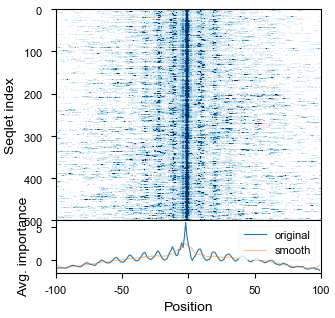

In [280]:
fig, axes = plt.subplots(2, 1, 
                         gridspec_kw=dict(height_ratios=[4, 1]),
                         figsize=get_figsize(.5, 1))
ax = axes[0]
heatmap_importance_profile(normalize(np.abs(p).sum(axis=-1)[:500], pmin=50, pmax=99), aspect='auto',
                           ax=ax)
ax.get_xaxis().set_visible(False)

ax=axes[1]
ax.plot(agg_profile, label='original')
ax.plot(smooth_part, label="smooth", alpha=0.5)
ax.legend()
ax.set_ylabel("Avg. importance")
ax.set_xlim([0, 200])
ax.set_xlabel("Position")
ax.set_xticklabels([-100, -50, 0, 50, 100])
# ax.set_title("Average importance score")
fig.subplots_adjust(hspace=0)  # no space between plots
fig.savefig(fdir / 'Nanog.p1.heatmap+avg.pdf')
fig.savefig(fdir / 'Nanog.p1.heatmap+avg.png')

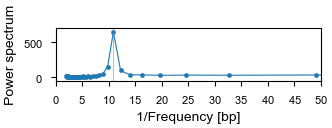

In [90]:
fft_fig, ax = plt.subplots(1, 1, figsize=get_figsize(0.5, 1/5))
x = 1 / freq[:49]
y = np.abs(np.fft.fft(oscilatory_part[102:])[:49])**2 + np.abs(np.fft.fft(oscilatory_part[:98])[:49])**2
t0 = x[np.argmax(y)]
ax.plot(x, y)
ax.scatter(x, y, s=10)
ax.set_xlim([0, 50])
ax.xaxis.set_major_locator(ticker.MaxNLocator(10, integer=True))
# ax.grid(alpha=0.3)
ax.axvline(x=t0, color='grey', alpha=0.5)
ax.set_xlabel("1/Frequency [bp]")
ax.set_ylabel("Power spectrum");
fft_fig.savefig(fdir / 'Nanog.p1.fft.pdf')

In [74]:
# Compute the frequency
oscilatory_part = agg_profile - smooth_part

freq_ebar = np.diff(freq)[0] / 2
lower = 1 / (freq[:49][np.argmax(y)] + freq_ebar)
center = t0
upper = 1 / (freq[:49][np.argmax(y)] - freq_ebar)

ebar = upper - center
print(f"t0: {center} +- {ebar}")

t0: 10.88888888888889 +- 0.6405228758169947


### Load the information from all the modisco runs


In [21]:
from basepair.utils import pd_col_prepend

In [22]:
def pd_column_replace(df):
    df.columns = [c.split(" ")[0] for c in df.columns]
    return df

In [23]:
dfp = pd.concat([
    (pd.read_csv(model_dir / f'deeplift/{tf}/out/{imp_score}/pattern_table.csv')
     .pipe(pd_col_prepend, 'pattern', tf + '/').set_index("pattern"))
    for tf in tasks
])

In [24]:
dfps = dfp[[f'{task} periodicity 10bp' for task in tasks]].pipe(pd_column_replace)
dfp= dfp[(dfp['n seqlets'] > 100)]

In [34]:
dfpsm = pd.melt(dfps.reset_index(), id_vars='pattern', value_vars=tasks, var_name='TF', value_name='10bp periodicity')
dfpsm['TF'] = pd.Categorical(dfpsm['TF'], categories=tasks, ordered=True)
dfpsm['task'] = dfpsm.pattern.str.split('/', expand=True).iloc[:, 0]

In [ ]:
dfpsm.to_csv(fdir / 'dfpsm.csv')

/users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 1.712595 x 2.5688925 in image.
  from_inches(height, units), units))
/users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: /users/avsec/workspace/basepair/data/figures/modisco/nexus,peaks,OSNK,0,10,1,FALSE,same,0.5,64,25,0.004,9,FALSE,[1,50],TRUE/periodicity/10bp-periodicity.boxplot.pdf
  warn('Filename: {}'.format(filename))


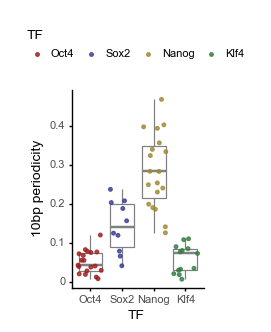

<ggplot: (8759399919659)>

In [73]:
plotnine.options.figure_size = get_figsize(.25, aspect=1.5)# (10, 10)
fig = (ggplot(aes(x='TF', y='10bp periodicity', color='TF'),
       dfpsm[dfpsm.TF == dfpsm.task]) + 
 geom_boxplot(color='grey') + 
 geom_jitter(size=1, alpha=0.8) + 
 theme_classic(base_size=10, base_family='Arial') + 
 theme(legend_position='top') + 
 scale_color_manual(values=[tf_colors[t] for t in tasks]))
fig.save(fdir / '10bp-periodicity.boxplot.pdf')
fig

In [38]:
dfpsm['short'] = dfpsm.pattern.str.split("/", expand=True)[1].str.replace("m0_p", "")

In [ ]:
(p9.ggplot(mtcars, p9.aes('mpg','disp')) + p9.geom_point()
      + p9.geom_text(p9.aes(label='name'), color='blue', position = p9.position_adjust_text(), size=7)
    )

In [42]:
import plotnine as p9

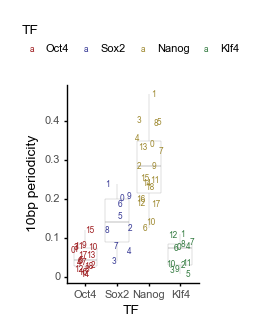

<ggplot: (-9223363303357819795)>

In [59]:
plotnine.options.figure_size = get_figsize(.25, aspect=1.5)# (10, 10)
fig = (ggplot(aes(x='TF', y='10bp periodicity', color='TF'),
       dfpsm[dfpsm.TF == dfpsm.task]) + 
 geom_boxplot(color='grey', size=0.1) + 
 geom_text(aes(label='short'), position = 'jitter', size=6) + 
 #geom_jitter(size=1, alpha=0.8) + 
 theme_classic(base_size=10, base_family='Arial') + 
 theme(legend_position='top') + 
 scale_color_manual(values=[tf_colors[t] for t in tasks]))
fig.save(fdir / '10bp-periodicity.boxplot.labeled.pdf')
fig